In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
# Cargar el dataset desde el archivo subido
df = pd.read_csv('online_retail-1.csv', encoding='latin1')

In [3]:
# --- Limpieza de Datos ---

# 1. Eliminar filas sin Customer ID, ya que son esenciales para el análisis
df.dropna(axis=0, subset=['Customer ID'], inplace=True)

# 2. Convertir Customer ID a tipo entero para consistencia
df['Customer ID'] = df['Customer ID'].astype(int)

# 3. Eliminar cantidades negativas (probables devoluciones)
df = df[df['Quantity'] > 0]

# 4. Crear la columna 'Revenue' (Gasto por transacción)
df['Revenue'] = df['Quantity'] * df['Price']

print("Datos después de la limpieza inicial:")
print(df.head())

Datos después de la limpieza inicial:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

    InvoiceDate  Price  Customer ID         Country  Revenue  
0  12/1/09 7:45   6.95        13085  United Kingdom     83.4  
1  12/1/09 7:45   6.75        13085  United Kingdom     81.0  
2  12/1/09 7:45   6.75        13085  United Kingdom     81.0  
3  12/1/09 7:45   2.10        13085  United Kingdom    100.8  
4  12/1/09 7:45   1.25        13085  United Kingdom     30.0  


In [4]:
# --- Ingeniería de Características ---

# Agrupar por cliente y calcular el gasto total y la frecuencia
customer_df = df.groupby('Customer ID').agg({
    'Revenue': 'sum',          # Gasto Total: Suma del Revenue
    'Invoice': 'nunique'       # Frecuencia: Conteo de facturas únicas
}).rename(columns={'Invoice': 'Frequency'})

print("\nDataset agregado por cliente:")
print(customer_df.head())


Dataset agregado por cliente:
             Revenue  Frequency
Customer ID                    
12346         372.86         11
12349        1268.52          2
12355         488.21          1
12358        1697.93          2
12359        2012.03          5


In [5]:
# --- Manejo de Outliers ---
# Eliminaremos los valores en el 1% superior para evitar que sesguen el modelo
high_revenue_threshold = customer_df['Revenue'].quantile(0.99)
high_freq_threshold = customer_df['Frequency'].quantile(0.99)

customer_df_clean = customer_df[(customer_df['Revenue'] < high_revenue_threshold) &
                                (customer_df['Frequency'] < high_freq_threshold)]

# --- Estandarización de Datos ---
# Seleccionamos solo las columnas para el clustering
features = customer_df_clean[['Revenue', 'Frequency']]

# Creamos una instancia del estandarizador
scaler = StandardScaler()

# Ajustamos y transformamos los datos
features_scaled = scaler.fit_transform(features)

# Convertimos el resultado de nuevo a un DataFrame para mayor claridad
features_scaled_df = pd.DataFrame(features_scaled, columns=['Revenue', 'Frequency'])

print("\nPrimeras 5 filas de datos estandarizados:")
print(features_scaled_df.head())


Primeras 5 filas de datos estandarizados:
    Revenue  Frequency
0 -0.458827   2.988309
1  0.150599  -0.300599
2 -0.380341  -0.666033
3  0.442779  -0.300599
4  0.656499   0.795703


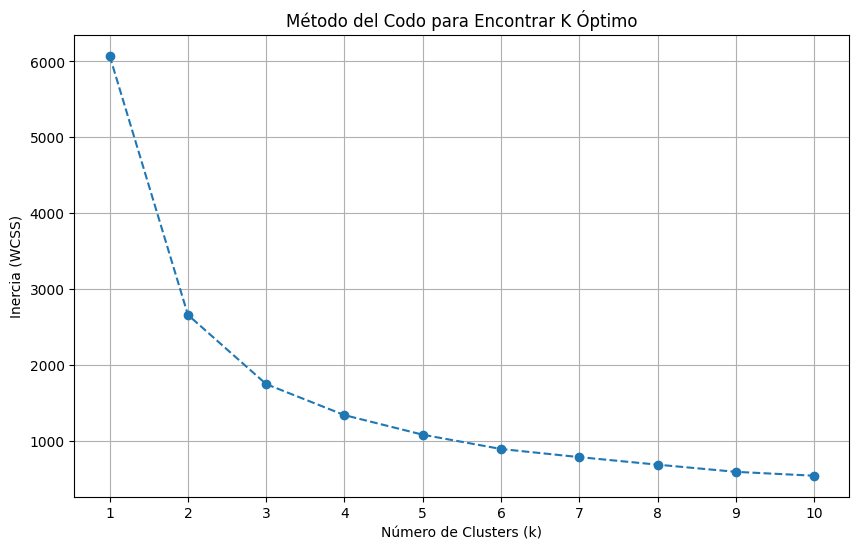

In [6]:
# --- Método del Codo para encontrar K óptimo ---

inertia = []
K_range = range(1, 11) # Probaremos con k desde 1 hasta 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init='auto' o 10
    kmeans.fit(features_scaled_df)
    inertia.append(kmeans.inertia_)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (WCSS)')
plt.title('Método del Codo para Encontrar K Óptimo')
plt.xticks(K_range)
plt.grid(True)
plt.show()

C:\Users\frado\AppData\Local\Temp\ipykernel_19324\1432704245.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_df_clean['Cluster'] = kmeans_final.labels_


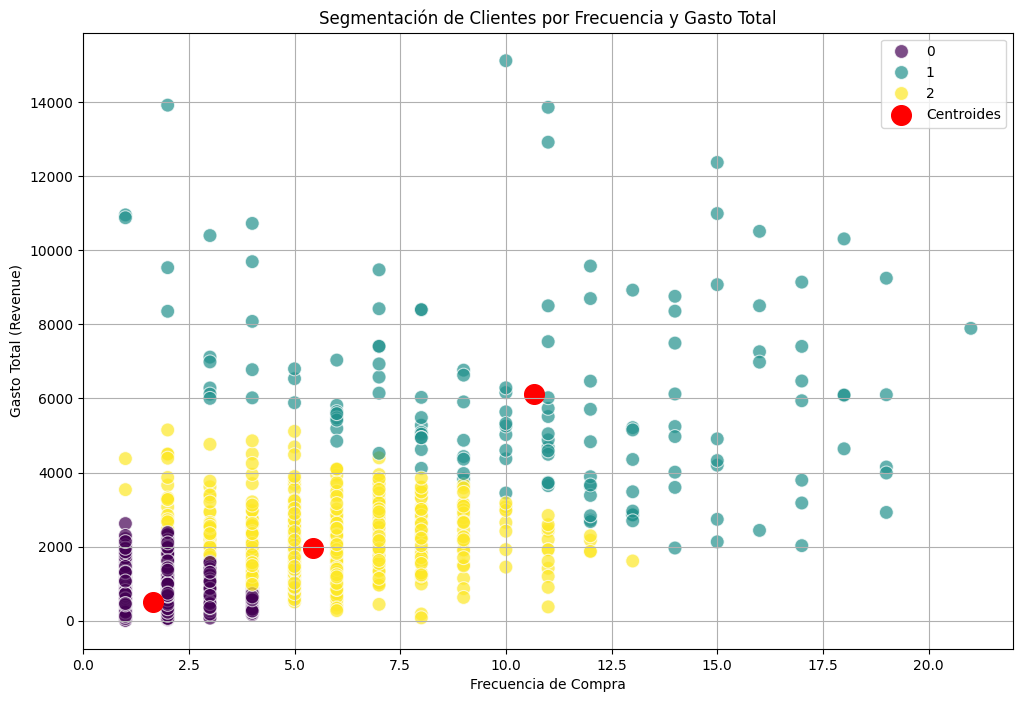

In [13]:
# --- Creación del Modelo K-Means con k=3 ---
optimal_k = 3
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_final.fit(features_scaled_df)

# Añadir las etiquetas de los clusters al DataFrame original (sin escalar)
customer_df_clean['Cluster'] = kmeans_final.labels_

# --- Visualización de los Clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=customer_df_clean,
    x='Frequency',
    y='Revenue',
    hue='Cluster',
    palette='viridis',
    s=100, # Tamaño de los puntos
    alpha=0.7 # Transparencia
)

# Obtener los centroides (hay que revertir la estandarización para graficarlos)
centroids = scaler.inverse_transform(kmeans_final.cluster_centers_)

# Graficar los centroides
plt.scatter(centroids[:, 1], centroids[:, 0], s=200, c='red', marker='o', label='Centroides')

plt.title('Segmentación de Clientes por Frecuencia y Gasto Total')
plt.xlabel('Frecuencia de Compra')
plt.ylabel('Gasto Total (Revenue)')
plt.legend()
plt.grid(True)
plt.show()